In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
random_seed = 11
torch.manual_seed(random_seed)
device = torch.device("cuda")

import numpy as np
np.random.seed(random_seed)
import matplotlib.pyplot as plt
import sys
import os

sys.path.append(os.path.abspath(os.path.join('..', 'ARRG')))
from ARRG_macro import *

import wasserstein_loss
import ot
import deepsets_classifier
import importlib
importlib.reload(wasserstein_loss)
importlib.reload(deepsets_classifier)
from wasserstein_loss import *
from deepsets_classifier import *

from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import scale

# Paths to the datasets on perlmutter
exp_hadrons_PATH = '/global/cfs/projectdirs/m3246/hadronization-tune-mlrw-data/pgun_qqbar_hadrons_a_0.68_b_0.98_sigma_0.335_N_1e6.npy'
sim_hadrons_PATH = '/global/cfs/projectdirs/m3246/hadronization-tune-mlrw-data/pgun_qqbar_hadrons_a_0.72_b_0.88_sigma_0.335_N_5e5.npy'
sim_accept_reject_PATH = '/global/cfs/projectdirs/m3246/hadronization-tune-mlrw-data/pgun_qqbar_accept_reject_z_a_0.72_b_0.88_sigma_0.335_N_5e5.npy'
sim_fPrel_PATH = '/global/cfs/projectdirs/m3246/hadronization-tune-mlrw-data/pgun_qqbar_fPrel_a_0.72_b_0.88_sigma_0.335_N_5e5.npy'

## Deepsets Classifier

In [5]:
# Load the arrays
exp_hadrons = np.load(exp_hadrons_PATH, mmap_mode="r")
sim_hadrons = np.load(sim_hadrons_PATH, mmap_mode="r")

# Extract the hadron multiplicity
N=50000
exp_mult = np.array([len(exp_hadrons[i,:][np.abs(exp_hadrons[i,:,0]) > 0.0]) for i in range(N)])
sim_mult = np.array([len(sim_hadrons[i,:][np.abs(sim_hadrons[i,:,0]) > 0.0]) for i in range(N)])
min_mult = min(exp_mult.min(), sim_mult.min())
max_mult = max(exp_mult.max(), sim_mult.max())
print("Max multiplicity:", max_mult)
exp_hadrons = exp_hadrons[:, :max_mult, :]
sim_hadrons = sim_hadrons[:, :max_mult, :]

# Extract (px, py, pz)
px_exp, py_exp, pz_exp = exp_hadrons[..., 0], exp_hadrons[..., 1], exp_hadrons[..., 2]
px_sim, py_sim, pz_sim = sim_hadrons[..., 0], sim_hadrons[..., 1], sim_hadrons[..., 2]
# Create masks for non-zero momentum entries
mask_exp = (px_exp != 0) | (py_exp != 0) | (pz_exp != 0)
mask_sim = (px_sim != 0) | (py_sim != 0) | (pz_sim != 0)

# Calculate transverse momentum (pT)
pt_exp = np.sqrt(px_exp**2 + py_exp**2)
pt_sim = np.sqrt(px_sim**2 + py_sim**2)

# Initialize arrays for the results with zeros
phi_exp = np.zeros_like(pt_exp)
phi_sim = np.zeros_like(pt_sim)
eta_exp = np.zeros_like(pt_exp)
eta_sim = np.zeros_like(pt_sim)

# Apply the calculations only where the mask is True (non-zero momentum)
phi_exp[mask_exp] = np.arctan2(py_exp[mask_exp], px_exp[mask_exp])
phi_sim[mask_sim] = np.arctan2(py_sim[mask_sim], px_sim[mask_sim])

theta_exp = np.arctan2(pt_exp[mask_exp], pz_exp[mask_exp])
theta_sim = np.arctan2(pt_sim[mask_sim], pz_sim[mask_sim])

eta_exp[mask_exp] = -np.log(np.tan(theta_exp / 2))
eta_sim[mask_sim] = -np.log(np.tan(theta_sim / 2))
# New observable: (pT, phi, eta)
exp_obs = np.stack([pt_exp, phi_exp, eta_exp], axis=-1)
sim_obs = np.stack([pt_sim, phi_sim, eta_sim], axis=-1)
# Print dataset shapes
print('Experimental observable shape:', exp_obs.shape)
print('Simulated observable shape:', sim_obs.shape)

# Restrict to a subset of the full dataset (for memory)

def prescale(exp_data, sim_data, axes=(0, 1)):
    # Mask to identify non-padded entries (i.e., entries that are not [0.0, 0.0, 0.0, 0.0])
    non_padded_mask_exp = ~(np.all(exp_data == 0, axis=-1))
    non_padded_mask_sim = ~(np.all(sim_data == 0, axis=-1))
    
    # Flatten the non-padded parts of the datasets along the specified axes for mean/std calculation
    combined_data = np.concatenate([exp_data[non_padded_mask_exp], sim_data[non_padded_mask_sim]], axis=0)
    combined_mean = combined_data.mean(axis=0)
    print("Mean:", combined_mean)
    combined_std = combined_data.std(axis=0)

    # Scale only the non-padded entries using the combined mean and std
    exp_data_scaled = np.copy(exp_data)
    sim_data_scaled = np.copy(sim_data)
    exp_data_scaled[non_padded_mask_exp] = (exp_data[non_padded_mask_exp] - combined_mean) / combined_std
    sim_data_scaled[non_padded_mask_sim] = (sim_data[non_padded_mask_sim] - combined_mean) / combined_std
    
    return exp_data_scaled, sim_data_scaled

N_events = int(500000)
exp_obs, sim_obs = prescale(exp_obs[0:N_events], sim_obs[0:N_events])
# Convert into torch objects
exp_obs = torch.Tensor(exp_obs.copy())#.to(device)
sim_obs = torch.Tensor(sim_obs.copy())#.to(device)
# Combine and split into training + validation and test sets
train_val_exp_obs, test_exp_obs = train_test_split(exp_obs, test_size=0.1, random_state=random_seed)
train_val_sim_obs, test_sim_obs = train_test_split(sim_obs, test_size=0.1, random_state=random_seed)
# Further split training + validation into separate training and validation sets
train_exp_obs, val_exp_obs = train_test_split(train_val_exp_obs, test_size=0.1, random_state=random_seed)  # 0.8 x 0.75 = 0.6
train_sim_obs, val_sim_obs = train_test_split(train_val_sim_obs, test_size=0.1, random_state=random_seed)

# Prepare data
batch_size=50000
num_workers = 4
train_exp_loader, train_sim_loader = prepare_data(train_exp_obs, train_sim_obs, batch_size=batch_size, num_workers=num_workers)
val_exp_loader, val_sim_loader = prepare_data(val_exp_obs, val_sim_obs, batch_size=batch_size, num_workers=num_workers)
test_exp_loader, test_sim_loader = prepare_data(test_exp_obs, test_sim_obs, batch_size=batch_size, num_workers=num_workers)

# Print dataset shapes
print('Experimental observable shape:', train_exp_obs.shape)
print('Simulated observable shape:', train_sim_obs.shape)

Max multiplicity: 32
Experimental observable shape: (1000000, 32, 3)
Simulated observable shape: (500000, 32, 3)
Mean: [ 4.00440497e-01 -9.85560640e-05  2.48141296e-04]
Experimental observable shape: torch.Size([405000, 32, 3])
Simulated observable shape: torch.Size([405000, 32, 3])


Number of learnable parameters: 11671
[-0.20021951 -0.64851785 -0.78294647 -0.7256253  -1.395902  ]


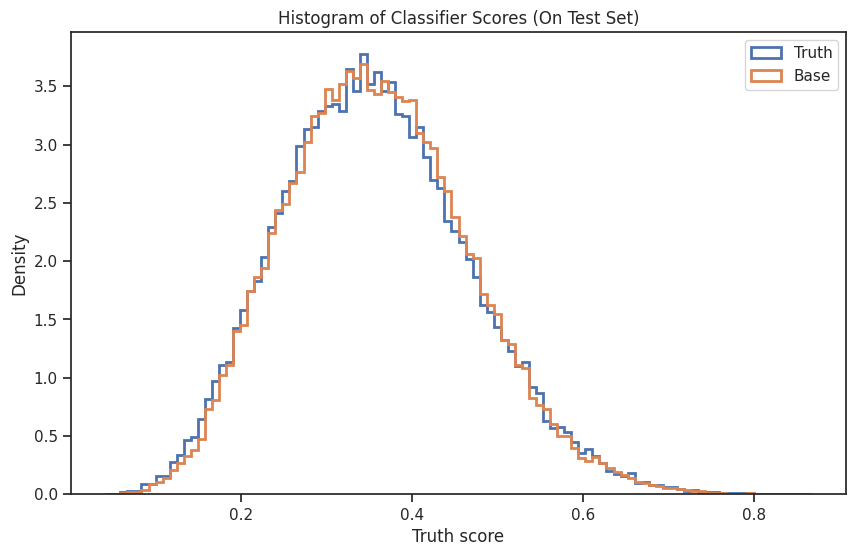

In [6]:
importlib.reload(deepsets_classifier)
from deepsets_classifier import *
torch.manual_seed(random_seed)
np.random.seed(random_seed)
# Usage example:
input_dim = 3
phi_hidden_dim=32
rho_hidden_dim=63
phi_layers=5
rho_layers=3
dropout_prob=0.5
mask_pad=True
classifier = DeepSetsClassifier(input_dim=input_dim, phi_hidden_dim=phi_hidden_dim, rho_hidden_dim=rho_hidden_dim,
                                phi_layers=phi_layers, rho_layers=rho_layers, device=device,
                                dropout_prob=dropout_prob, mask_pad=mask_pad).to(device)
load_pretrain=False
if not load_pretrain:
    # Change initial weights
    for m in classifier.modules():
        if isinstance(m, nn.Linear):
            # for full phase space:
            nn.init.xavier_normal_(m.weight, gain=nn.init.calculate_gain('leaky_relu'))
            #nn.init.kaiming_uniform_(m.weight, a=0.1, mode="fan_in", nonlinearity="leaky_relu") 
            #nn.init.uniform_(m.bias,-1.1,0.3)#, -2, 2)# a=-1, b=0.5) # center at 0.5 if possible

    classifier.eval() # never forget
    print(classifier(test_exp_obs[:5]).cpu().detach().numpy()) # for debugging
    test_exp_scores = torch.sigmoid(classifier(test_exp_obs)).cpu().detach().numpy()
    test_sim_scores = torch.sigmoid(classifier(test_sim_obs)).cpu().detach().numpy()
    plot_score_histogram(test_exp_scores, test_sim_scores, same_bins=True, bins=100)

In [7]:
train=False
if train:
    pretraining_epochs = 0
    epochs=10
    lr=1e-4
    classifier.train_classifier(train_exp_loader, train_sim_loader, val_exp_loader, val_sim_loader, 
                                device=device, num_epochs=epochs, learning_rate=lr, pretraining_epochs=pretraining_epochs)
    torch.save(classifier.state_dict(), "deepsets_classifier.pth")
else:
    classifier.load_state_dict(torch.load("deepsets_classifier.pth"))

cuda


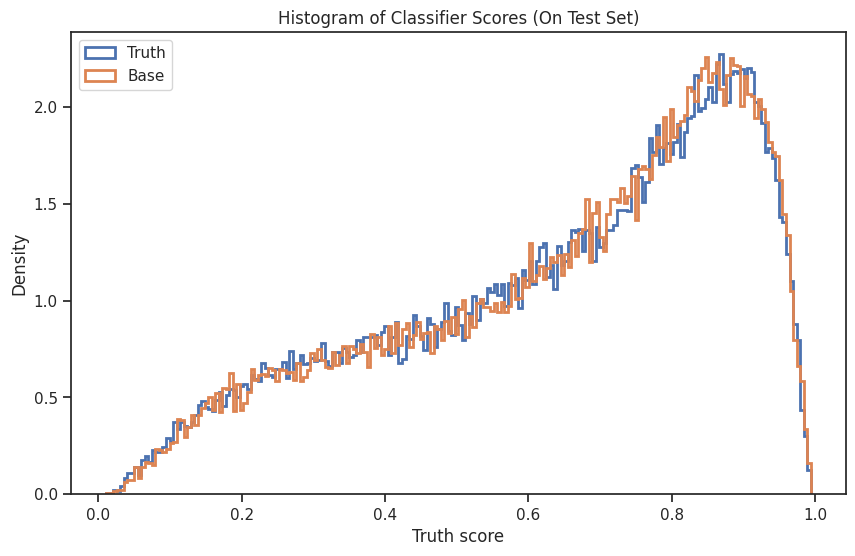

In [8]:
classifier.eval()
eval_device = "cuda"
test_scores = torch.sigmoid(classifier(torch.cat([test_exp_obs,test_sim_obs]), device=eval_device)).cpu().detach().numpy()
test_exp_scores = test_scores[:test_exp_obs.size(0)]
test_sim_scores = test_scores[test_exp_obs.size(0):]
plot_score_histogram(test_exp_scores, test_sim_scores, same_bins=True, bins=200)
#plot_score_histogram(test_exp_scores/(1-test_exp_scores), test_sim_scores/(1-test_sim_scores), same_bins=True, bins=200)
#print(test_exp_scores)
#train_exp_scores = torch.sigmoid(classifier(train_exp_obs)).cpu().detach().numpy()
#train_sim_scores = torch.sigmoid(classifier(train_sim_obs)).cpu().detach().numpy()
#plot_score_histogram(train_exp_scores, train_sim_scores, same_bins=True, bins=200)

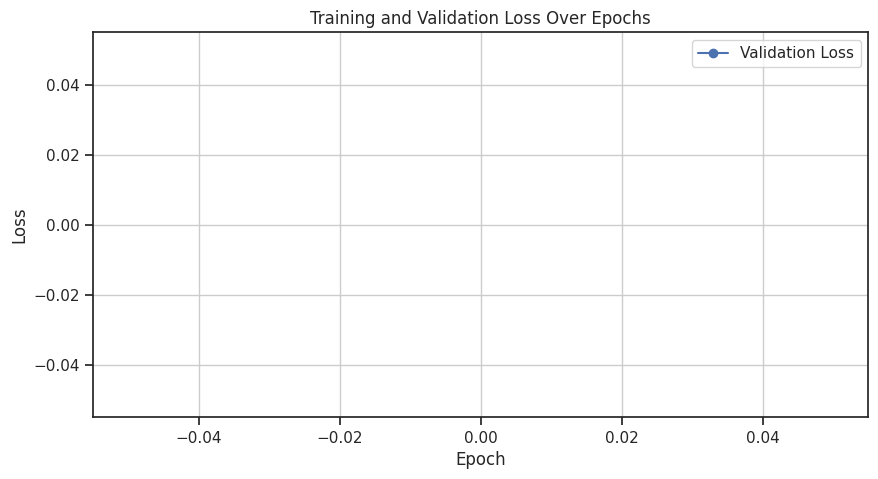

In [9]:
plt.figure(figsize=(10, 5))
#plt.plot(classifier.train_loss[4:], label='Training Loss', marker='o')
start_epoch=10
plt.plot(np.arange(start_epoch,len(classifier.val_loss)), classifier.val_loss[start_epoch:], label='Validation Loss', marker='o')
#plt.plot(classifier.train_loss, label='Train Loss', marker='o')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.legend()
plt.grid(True)
plt.show()

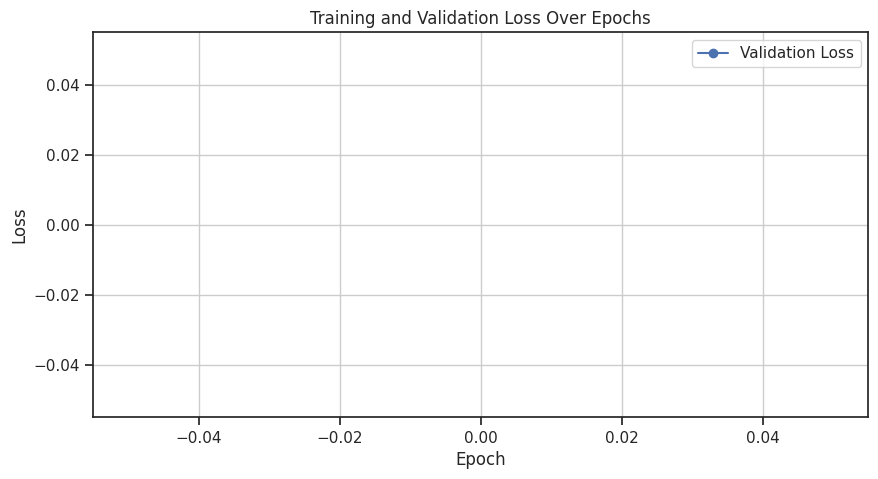

In [10]:
plt.figure(figsize=(10, 5))
#plt.plot(classifier.train_loss[4:], label='Training Loss', marker='o')
start_epoch=50
plt.plot(np.arange(start_epoch,len(classifier.train_loss)), classifier.train_loss[start_epoch:], label='Validation Loss', marker='o')
#plt.plot(classifier.train_loss, label='Train Loss', marker='o')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.legend()
plt.grid(True)
plt.show()

## Wasserstein Weight Tuning

In [63]:
importlib.reload(wasserstein_loss)
from wasserstein_loss import *
#classifier.phi.cpu()
#classifier.rho.cpu()

sim_accept_reject = np.load(sim_accept_reject_PATH, mmap_mode = "r")
sim_fPrel         = np.load(sim_fPrel_PATH, mmap_mode = "r")

N_events = 25000#min(len(sim_accept_reject), 50000)
print("N_events:", N_events)

sim_accept_reject = torch.Tensor(sim_accept_reject[0:N_events].copy()).to(device) # z values
# Check the accepted z-values, if z == 1 reduce it by epsilon (a very nasty bug to find).
# The a-coefficient when computing the likelihood has a term propotional to log(1-z). If 
# z = 1, this term diverges to -inf and completely destroys the backward pass.
epsilon = 1e-5
sim_accept_reject[sim_accept_reject == 1] = 1 - epsilon
sim_fPrel = torch.Tensor(sim_fPrel[0:N_events].copy()).to(device)

print('Simulated z shape:', sim_accept_reject.shape)
print('Simulated fPrel shape:', sim_fPrel.shape)

# Pre-sort the data
def presort_data(exp_data, sim_data, sim_fPrel, sim_accept_reject):
    
    if exp_data.dim() == 1:
        # Combine exp_scores and sim_scores
        combined_scores = torch.cat((exp_data, sim_data))

        # Sort the combined scores
        sorted_scores, sorted_indices = torch.sort(combined_scores)

        # Determine the number of experimental scores
        exp_count = len(exp_scores)

        # Create a mask to separate the sorted scores into exp and sim
        exp_mask = sorted_indices < exp_count

        # Separate the sorted scores
        sorted_exp_scores = sorted_scores[exp_mask]
        sorted_sim_scores = sorted_scores[~exp_mask]

        # Adjust the sim indices for sorting sim_fPrel and sim_accept_reject
        sim_sorted_indices = sorted_indices[~exp_mask] - exp_count
        sorted_sim_fPrel = sim_fPrel[sim_sorted_indices]
        sorted_sim_accept_reject = sim_accept_reject[sim_sorted_indices]
    
        return sorted_exp_scores, sorted_sim_scores, sorted_sim_fPrel, sorted_sim_accept_reject
    
    else:
        # In the case of multiple dimensions, no sort
        return exp_data, sim_data, sim_fPrel, sim_accept_reject

# Modify the CombinedDataset class to handle pre-sorted data
class CombinedDataset(Dataset):
    def __init__(self, exp_obs, sim_obs, sim_fPrel, sim_accept_reject, pre_sorted=False):
        if not pre_sorted:
            self.exp_obs, self.sim_obs, self.sim_fPrel, self.sim_accept_reject = presort_data(
                exp_obs, sim_obs, sim_fPrel, sim_accept_reject
            )
        else:
            self.exp_obs = exp_obs
            self.sim_obs = sim_obs
            self.sim_fPrel = sim_fPrel
            self.sim_accept_reject = sim_accept_reject
        
        assert len(self.exp_obs) == len(self.sim_obs) == len(self.sim_fPrel) == len(self.sim_accept_reject), "All inputs must have the same length"

    def __len__(self):
        return len(self.exp_obs)

    def __getitem__(self, idx):
        return {
            'exp_data': self.exp_obs[idx],
            'sim_data': self.sim_obs[idx],
            'sim_fPrel': self.sim_fPrel[idx],
            'sim_accept_reject': self.sim_accept_reject[idx],
        }

N_events: 25000
Simulated z shape: torch.Size([25000, 105, 101])
Simulated fPrel shape: torch.Size([25000, 105, 100])


In [36]:
# Your existing code for data processing
exp_scores = torch.sigmoid(classifier.forward(exp_obs[:N_events], device="cpu")).to(device).detach()
sim_scores = torch.sigmoid(classifier.forward(sim_obs[:N_events], device="cpu")).to(device).detach()
#exp_scores = torch.tensor(np.load("exp_scores.npy")).to(device)
#sim_scores = torch.tensor(np.load("sim_scores.npy")).to(device)
# Create the dataset with pre-sorted data
train_dataset = CombinedDataset(exp_scores[:N_events], sim_scores[:N_events], sim_fPrel[:N_events], sim_accept_reject[:N_events], pre_sorted=False)
#val_dataset = CombinedDataset(exp_scores[:10], sim_scores[:10], sim_fPrel[:10], sim_accept_reject[:10], pre_sorted=False)

# Create DataLoaders
batch_size = N_events  # You can adjust this as needed
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)
#val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

N_events: 25000
Simulated z shape: torch.Size([25000, 105, 101])
Simulated fPrel shape: torch.Size([25000, 105, 100])
cpu
cpu


In [37]:
importlib.reload(wasserstein_loss)
from wasserstein_loss import *

params_base = torch.tensor([0.72, 0.88])
params_init = torch.tensor([0.72, 0.88])
# True parameters (0.68, 0.98)
over_sample_factor = 10.0
# initialize weight module
weight_nexus_tune = LundWeight(params_base, params_init, over_sample_factor = over_sample_factor).to("cuda")
tuner = Wasserstein_Tuner(weight_nexus_tune, learning_rate=0.05, loss = ot.wasserstein_1d)

In [29]:
tuner.train(train_loader, val_loader=None,num_epochs=20)

a_history = [p['params_a'] for p in tuner.param_history]
b_history = [p['params_b'] for p in tuner.param_history]

plt.plot(a_history, b_history, marker='o')
plt.scatter(params_base[0], params_base[1], marker='o', s=100, color="red", label="Base")
plt.scatter(0.68, 0.98, marker='x', color="green", label="Truth")

# Add dashed lines
plt.axvline(x=0.68, color='green', linestyle='--')
plt.axhline(y=0.98, color='green', linestyle='--')

plt.title("Parameters (a,b) over epochs")
plt.legend()
plt.show()

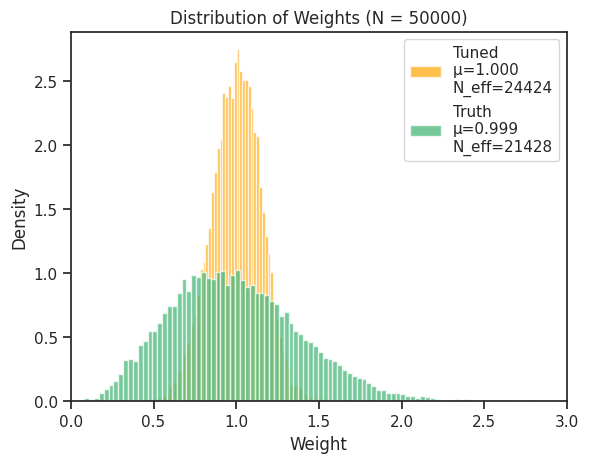

In [30]:
#weight_nexus = LundWeight(params_base, torch.tensor([0.68,0.98]), over_sample_factor = over_sample_factor).to(device)
truth_weights = LundWeight(params_base, torch.tensor([0.68,0.98]), 
                           over_sample_factor = over_sample_factor).to(device)(sim_accept_reject[:N_events], sim_fPrel[:N_events]).cpu().detach().numpy()
tuned_weights = weight_nexus_tune(sim_accept_reject[:N_events], sim_fPrel[:N_events]).cpu().detach().numpy()
# Calculate means
truth_mean = np.mean(truth_weights)
tuned_mean = np.mean(tuned_weights)
truth_neff = np.sum(truth_weights)**2/np.sum(truth_weights**2)
tuned_neff = np.sum(tuned_weights)**2/np.sum(tuned_weights**2)

max_w = 3
plt.hist(tuned_weights[tuned_weights < max_w], color='orange', bins=100, label=f"Tuned \nμ={tuned_mean:.3f} \nN_eff={tuned_neff:.5g}", alpha=0.7, density=True)
plt.hist(truth_weights[truth_weights < max_w], color='mediumseagreen', bins=100, label=f"Truth \nμ={truth_mean:.3f}\nN_eff={truth_neff:.5g}", alpha=0.7, density=True)
plt.xlim(0, max_w)
plt.legend()

plt.xlabel("Weight")
plt.ylabel("Density")
plt.title("Distribution of Weights (N = 50000)")
plt.show()

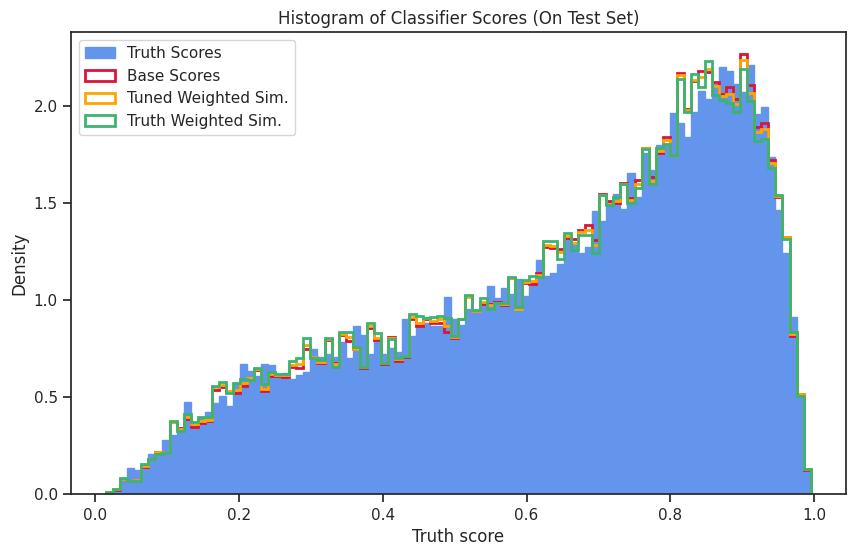

In [31]:
truth_weights = np.array(truth_weights)
#tuned_weights = np.array(tuned_weights)

bins=100
min_score = min(exp_scores.min().cpu().detach().numpy(), sim_scores.min().cpu().detach().numpy())
max_score = max(exp_scores.max().cpu().detach().numpy(), sim_scores.max().cpu().detach().numpy())
bin_edges = np.linspace(min_score, max_score, bins + 1)

plt.figure(figsize=(10, 6))

# Plot histogram for experimental scores as a line
exp_scores_det = exp_scores[:N_events].cpu().detach().numpy()
sim_scores_det = sim_scores[:N_events].cpu().detach().numpy()
plt.hist(exp_scores_det, bins=bin_edges, density=True, color='cornflowerblue', edgecolor='cornflowerblue', label="Truth Scores")
plt.hist(sim_scores_det, bins=bin_edges, density=True, color='crimson', histtype='step', linewidth=2, label="Base Scores")
plt.hist(sim_scores_det, bins=bin_edges, density=True, color='orange', histtype='step', linewidth=2,
         weights=tuned_weights, label="Tuned Weighted Sim.")
plt.hist(sim_scores_det, bins=bin_edges, density=True, color='mediumseagreen', histtype='step', linewidth=2,
         weights=truth_weights, label="Truth Weighted Sim.")

plt.title('Histogram of Classifier Scores (On Test Set)')
plt.xlabel('Truth score')
plt.ylabel('Density')
plt.legend()
plt.show()

In [32]:
# Define a grid of initial parameters
a_range  = (0.53, 0.84)
b_range  = (0.75, 1.1)
n_points = 20
a_b_init = a_b_grid(a_range, b_range, n_points)

params_base = torch.tensor([0.72, 0.88])
params_init = torch.tensor([0.72, 0.88])
# True parameters (0.68, 0.98)
over_sample_factor = 10.0
# initialize weight module
weight_nexus = LundWeight(params_base, params_init, over_sample_factor = over_sample_factor).to(device)
tuner = Wasserstein_Tuner(weight_nexus, learning_rate=0.005)
a_b_gradients, loss_grid = tuner.Wasserstein_flow(train_loader, a_b_init)

Wasserstein Flow: 100%|███████████████████████████████████████████| 400/400 [03:19<00:00,  2.01it/s]


(0.75, 1.1)

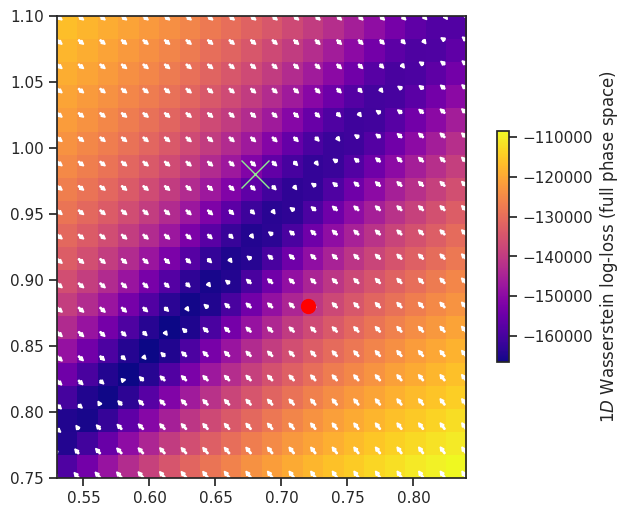

In [39]:
# Clone a_b_init into numpy array
a_b = a_b_init.detach().numpy()

import matplotlib.colors as mcolors

# Calculate the magnitude of each vector in a_b_gradients
magnitudes = np.linalg.norm(a_b_gradients, axis=1)


fig, ax = plt.subplots(1,1,figsize=(8,6))

# Set the background color based on the magnitude
# Normalize the magnitude to use it with the colormap
norm = mcolors.Normalize(vmin=np.min(magnitudes), vmax=np.max(magnitudes))
cmap = plt.cm.plasma  # Choose a colormap

# Assuming magnitudes can be reshaped into a grid directly for simplicity
# In a real scenario, you might need to interpolate these values onto a grid
grid_shape = (int(np.sqrt(len(magnitudes))), int(np.sqrt(len(magnitudes))))
magnitudes_grid = magnitudes.reshape(grid_shape).T

# Create a heatmap of the gradient magnitudes
#heatmap = ax.imshow(magnitudes_grid, cmap=cmap, norm=norm, origin='lower', extent=(np.min(a_b[:, 0]), np.max(a_b[:, 0]), np.min(a_b[:, 1]), np.max(a_b[:, 1])))
heatmap = ax.imshow((np.log(loss_grid) * N_events).reshape(grid_shape).T, cmap=cmap, origin='lower', extent=(np.min(a_b[:, 0]), np.max(a_b[:, 0]), np.min(a_b[:, 1]), np.max(a_b[:, 1])))

# Add a colorbar to show the magnitude scale
fig.colorbar(heatmap, ax=ax, label=r'$1D$ Wasserstein log-loss (full phase space)', shrink=0.5)

# Plot arrows for each point and direction
scale = 2e1
for point, gradient in zip(a_b, a_b_gradients):
    ax.arrow(point[0], point[1], gradient[0]/scale, gradient[1]/scale, head_width=0.003, head_length=0.003, fc='w', ec='w')

a_b_target = np.array([0.68, 0.98]) # Monash
ax.plot(a_b_target[0], a_b_target[1], 'x', color='lightgreen', label = 'Target', ms = 20, linewidth=30)#label = r'$\mathrm{Target}$')
a_b_initial = np.array([0.72, 0.88]) # Monash
ax.plot(a_b_initial[0], a_b_initial[1], 'o', color='red', label = 'Initial', ms = 10, linewidth=10)#label = r'$\mathrm{Target}$')
ax.set_xlim(a_range)
ax.set_ylim(b_range)

## Tune with multiplicity and slicing

In [40]:
n_samples_a = 20

X = np.random.normal(0., 1., (n_samples_a, 5))
print(X.shape)
ot.sliced_wasserstein_distance(X, X, seed=0)  

(20, 5)


0.0

In [117]:
importlib.reload(wasserstein_loss)
from wasserstein_loss import *
device = "cuda"
#classifier.phi.cpu()
#classifier.rho.cpu()

exp_hadrons = np.load(exp_hadrons_PATH, mmap_mode="r")
sim_hadrons = np.load(sim_hadrons_PATH, mmap_mode="r")
sim_accept_reject = np.load(sim_accept_reject_PATH, mmap_mode = "r")
sim_fPrel         = np.load(sim_fPrel_PATH, mmap_mode = "r")

N_events = 25000
print("N_events:", N_events)

sim_accept_reject = torch.Tensor(sim_accept_reject[0:N_events].copy()).to(device) # z values
epsilon = 1e-5
sim_accept_reject[sim_accept_reject == 1] = 1 - epsilon
sim_fPrel = torch.Tensor(sim_fPrel[0:N_events].copy()).to(device)

print('Simulated z shape:', sim_accept_reject.shape)
print('Simulated fPrel shape:', sim_fPrel.shape)

exp_scores = torch.sigmoid(classifier.forward(exp_obs[:N_events], device="cpu")).cpu().detach().numpy()
sim_scores = torch.sigmoid(classifier.forward(sim_obs[:N_events], device="cpu")).cpu().detach().numpy()
exp_mult = np.array([len(exp_hadrons[i,:][np.abs(exp_hadrons[i,:,0]) > 0.0]) for i in range(N_events)])
sim_mult = np.array([len(sim_hadrons[i,:][np.abs(sim_hadrons[i,:,0]) > 0.0]) for i in range(N_events)])

exp_data = np.concatenate((np.reshape(exp_scores, (-1, 1)), np.reshape(exp_mult, (-1, 1))), axis=1)
sim_data = np.concatenate((np.reshape(sim_scores, (-1, 1)), np.reshape(sim_mult, (-1, 1))), axis=1)
print(exp_data.shape)
print(sim_data.shape)
exp_data = torch.tensor(exp_data).to(device)
sim_data = torch.tensor(sim_data).to(device)

N_events: 25000
Simulated z shape: torch.Size([25000, 105, 101])
Simulated fPrel shape: torch.Size([25000, 105, 100])
cpu
cpu
(25000, 2)
(25000, 2)


In [118]:
train_dataset = CombinedDataset(exp_data[:N_events], sim_data[:N_events], sim_fPrel[:N_events], sim_accept_reject[:N_events], pre_sorted=True)
# Create DataLoaders
batch_size = N_events  # You can adjust this as needed
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)

In [142]:
importlib.reload(wasserstein_loss)
from wasserstein_loss import *

params_base = torch.tensor([0.72, 0.88])
params_init = torch.tensor([0.72, 0.88])
# True parameters (0.68, 0.98)
over_sample_factor = 10.0
# initialize weight module
weight_nexus_tune = LundWeight(params_base, params_init, over_sample_factor = over_sample_factor).to("cuda")
tuner = Wasserstein_Tuner(weight_nexus_tune, learning_rate=0.001, loss = ot.sliced_wasserstein_distance)

In [182]:
tuner.train(train_loader, val_loader=None,num_epochs=30)

Beginning parameter tuning...
Initial (a, b): (0.6734, 0.9799)


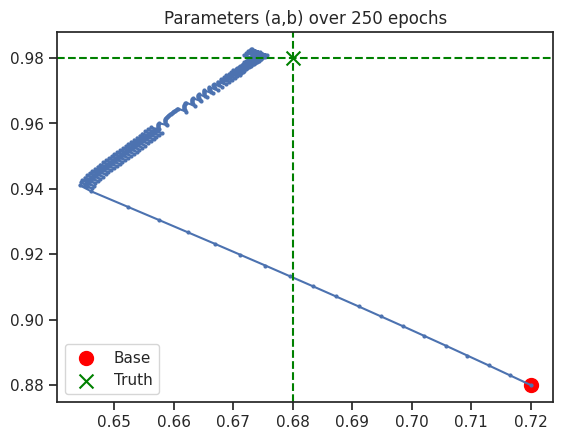

In [183]:
a_history = [p['params_a'] for p in tuner.param_history]
b_history = [p['params_b'] for p in tuner.param_history]

plt.plot(a_history, b_history, marker='o', markersize=2)
plt.scatter(params_base[0], params_base[1], marker='o', s=100, color="red", label="Base")
plt.scatter(0.68, 0.98, marker='x', s=100, color="green", label="Truth")

# Add dashed lines
plt.axvline(x=0.68, color='green', linestyle='--')
plt.axhline(y=0.98, color='green', linestyle='--')

plt.title(f"Parameters (a,b) over {len(a_history)-1} epochs")
plt.legend()
plt.show()

In [ ]:
# Define a grid of initial parameters
a_range  = (0.6, 0.8)
b_range  = (0.8, 1.1)
n_points = 20
a_b_init = a_b_grid(a_range, b_range, n_points)

params_base = torch.tensor([0.72, 0.88])
params_init = torch.tensor([0.72, 0.88])
# True parameters (0.68, 0.98)
over_sample_factor = 10.0
# initialize weight module
weight_nexus = LundWeight(params_base, params_init, over_sample_factor = over_sample_factor).to(device)
tuner = Wasserstein_Tuner(weight_nexus_tune, learning_rate=0.001, loss = ot.sliced_wasserstein_distance)
a_b_gradients, loss_grid = tuner.Wasserstein_flow(train_loader, a_b_init)

Wasserstein Flow:  35%|██████████████▉                            | 139/400 [01:27<02:36,  1.66it/s]

(0.75, 1.1)

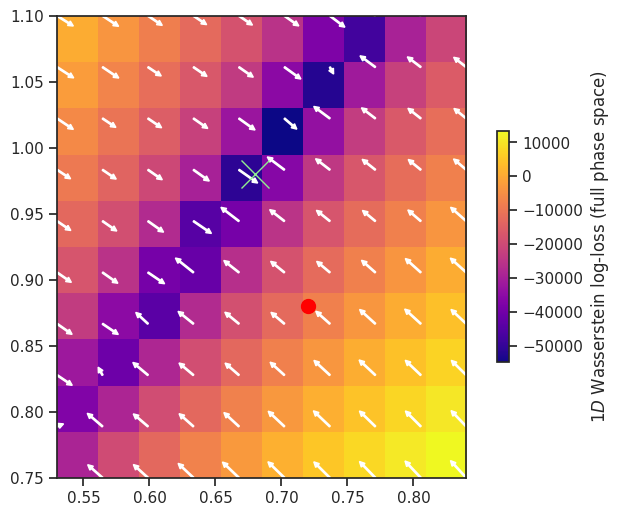

In [140]:
# Clone a_b_init into numpy array
a_b = a_b_init.detach().numpy()

import matplotlib.colors as mcolors

# Calculate the magnitude of each vector in a_b_gradients
magnitudes = np.linalg.norm(a_b_gradients, axis=1)


fig, ax = plt.subplots(1,1,figsize=(8,6))

# Set the background color based on the magnitude
# Normalize the magnitude to use it with the colormap
norm = mcolors.Normalize(vmin=np.min(magnitudes), vmax=np.max(magnitudes))
cmap = plt.cm.plasma  # Choose a colormap

# Assuming magnitudes can be reshaped into a grid directly for simplicity
# In a real scenario, you might need to interpolate these values onto a grid
grid_shape = (int(np.sqrt(len(magnitudes))), int(np.sqrt(len(magnitudes))))
magnitudes_grid = magnitudes.reshape(grid_shape).T

# Create a heatmap of the gradient magnitudes
#heatmap = ax.imshow(magnitudes_grid, cmap=cmap, norm=norm, origin='lower', extent=(np.min(a_b[:, 0]), np.max(a_b[:, 0]), np.min(a_b[:, 1]), np.max(a_b[:, 1])))
heatmap = ax.imshow((np.log(loss_grid) * N_events).reshape(grid_shape).T, cmap=cmap, origin='lower', extent=(np.min(a_b[:, 0]), np.max(a_b[:, 0]), np.min(a_b[:, 1]), np.max(a_b[:, 1])))

# Add a colorbar to show the magnitude scale
fig.colorbar(heatmap, ax=ax, label=r'Sliced Wasserstein log-loss (full phase space)', shrink=0.5)

# Plot arrows for each point and direction
scale = 5e2
for point, gradient in zip(a_b, a_b_gradients):
    ax.arrow(point[0], point[1], gradient[0]/scale, gradient[1]/scale, head_width=0.004, head_length=0.004, fc='w', ec='w')

a_b_target = np.array([0.68, 0.98]) # Monash
ax.plot(a_b_target[0], a_b_target[1], 'x', color='lightgreen', label = 'Target', ms = 20, linewidth=30)#label = r'$\mathrm{Target}$')
a_b_initial = np.array([0.72, 0.88]) # Monash
ax.plot(a_b_initial[0], a_b_initial[1], 'o', color='red', label = 'Initial', ms = 10, linewidth=10)#label = r'$\mathrm{Target}$')
ax.set_xlim(a_range)
ax.set_ylim(b_range)